In [2]:
import numpy as np
import pandas as pd 
import os
import json
import torch
from torchvision import transforms
from torch.nn import functional as F
import random
import argparse
from models import vae
from models import vae_reward
from models import vae_vgg 
from models import vaernn_no_gmm 
from models import vr
from sklearn.metrics import precision_recall_fscore_support
from collections import Counter 
from collections import OrderedDict

import pickle

from utils.misc import LSIZE, RED_SIZE, ASIZE, RSIZE

from data.loaders import RolloutObservationDataset
from data.loaders import RolloutSequenceDataset
from data.loaders import RolloutRewardDataset

os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

/Users/megumisano/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/megumisano/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/megumisano/anaconda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
device = torch.device('cpu')

In [4]:
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [5]:
### Set directory paths 
DATA_DIR = "/home/gengar888/world-models/rollouts/"
vae_dir = "/home/megumisano/world-models/exp_dir/vae"  
vae_reward_dir = "/home/megumisano/world-models/exp_dir/vae_reward" 
vae_reward_eval_dir = "/home/megumisano/world-models/exp_dir/vae_reward_eval"
vae_vgg_dir = "/home/gengar888/world-models/exp_dir/vgg"
vae_rnn_dir = "/home/gengar888/enhanced_world_models/exp_dir/vaernn_no_gmm"
vae_rnn_frozen_dir = "/home/gengar888/enhanced_world_models/exp_dir/vaernn"

In [6]:
### Load observation dataset (without reward)
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
])

dataset_test = RolloutObservationDataset(DATA_DIR,
                                         transform_test, train=False)

test_loader_no_reward = torch.utils.data.DataLoader(
    dataset_test, batch_size=32, shuffle=True, num_workers=0)

dataset_test.load_next_buffer()

Loading file buffer ...: 100%|██████████| 200/200 
Loading file buffer ...: 100%|██████████| 200/200 


In [39]:
### Load sequence datset (with reward)
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((RED_SIZE, RED_SIZE)),
    transforms.ToTensor(),
])

test_loader_with_reward = torch.utils.data.DataLoader(
    RolloutRewardDataset(DATA_DIR, transform_test, train=False, buffer_size=10),
    batch_size=32, num_workers=0)

test_loader_with_reward.dataset.load_next_buffer()


  0%|          | 0/10 
Loading file buffer ...:   0%|          | 0/10 
Loading file buffer ...:  30%|███       | 3/10 
Loading file buffer ...:  60%|██████    | 6/10 
Loading file buffer ...:  90%|█████████ | 9/10 
Loading file buffer ...: 100%|██████████| 10/10 

### Loading retrained VAE and ResNet50 

In [7]:
# Load VAE 
vae_ = vae.VAE(3, LSIZE)
reload_file = os.path.join(vae_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [9]:
# Load VAE with reward 
vae_reward_ = vae_reward.VAE(3, LSIZE)
reload_file = os.path.join(vae_reward_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_reward_.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
# Load VAE with reward 
vae_vgg= vae_vgg.VAE_VGG(3, LSIZE)
reload_file = os.path.join(vae_vgg_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_vgg.load_state_dict(state['state_dict'], strict=False)

KeyboardInterrupt: 

In [10]:
# Load VAE with reward  eval 
vae_reward_eval = vae_reward.VAE(3, LSIZE)
reload_file = os.path.join(vae_reward_eval_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_reward_eval.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
# Load VAE RNN 
vae_rnn = vaernn_no_gmm.VAERNN_NOGMM(LSIZE, ASIZE, RSIZE, 5)
reload_file = os.path.join(vae_rnn_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_rnn.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
# Load VAE RNN 
vae_rnn_frozen = vr.VAERNN(LSIZE, ASIZE, RSIZE, 5)
reload_file = os.path.join(vae_rnn_frozen_dir, 'best.tar')
state = torch.load(reload_file, map_location=lambda storage, loc: storage)
vae_rnn_frozen.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [12]:
# Convert state dict so that we can load just VAE weights 
new = OrderedDict()
for key, value in state['state_dict'].items():
    if key.startswith('vae'):
        prev = key
        new[prev[4:]] = value
state['state_dict'].update(new)

In [13]:
# Load just VAE weights 
vae_from_vaernn = vae.VAE(3, LSIZE)
vae_from_vaernn.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['obs_linear.weight', 'obs_linear.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'vae.encoder.conv1.weight', 'vae.encoder.conv1.bias', 'vae.encoder.conv2.weight', 'vae.encoder.conv2.bias', 'vae.encoder.conv3.weight', 'vae.encoder.conv3.bias', 'vae.encoder.conv4.weight', 'vae.encoder.conv4.bias', 'vae.encoder.fc_mu.weight', 'vae.encoder.fc_mu.bias', 'vae.encoder.fc_logsigma.weight', 'vae.encoder.fc_logsigma.bias', 'vae.decoder.fc1.weight', 'vae.decoder.fc1.bias', 'vae.decoder.deconv1.weight', 'vae.decoder.deconv1.bias', 'vae.decoder.deconv2.weight', 'vae.decoder.deconv2.bias', 'vae.decoder.deconv3.weight', 'vae.decoder.deconv3.bias', 'vae.decoder.deconv4.weight', 'vae.decoder.deconv4.bias'])

In [15]:
# Convert state dict so that we can load just VAE weights 
new = OrderedDict()
for key, value in state['state_dict'].items():
    if key.startswith('vae'):
        prev = key
        new[prev[4:]] = value
state['state_dict'].update(new)

In [16]:
# Load just VAE weights 
vae_from_vaernn_frozen = vae.VAE(3, LSIZE)
vae_from_vaernn_frozen.load_state_dict(state['state_dict'], strict=False)

IncompatibleKeys(missing_keys=[], unexpected_keys=['gmm_linear.weight', 'gmm_linear.bias', 'rnn.weight_ih_l0', 'rnn.weight_hh_l0', 'rnn.bias_ih_l0', 'rnn.bias_hh_l0', 'vae.encoder.conv1.weight', 'vae.encoder.conv1.bias', 'vae.encoder.conv2.weight', 'vae.encoder.conv2.bias', 'vae.encoder.conv3.weight', 'vae.encoder.conv3.bias', 'vae.encoder.conv4.weight', 'vae.encoder.conv4.bias', 'vae.encoder.fc_mu.weight', 'vae.encoder.fc_mu.bias', 'vae.encoder.fc_logsigma.weight', 'vae.encoder.fc_logsigma.bias', 'vae.decoder.fc1.weight', 'vae.decoder.fc1.bias', 'vae.decoder.deconv1.weight', 'vae.decoder.deconv1.bias', 'vae.decoder.deconv2.weight', 'vae.decoder.deconv2.bias', 'vae.decoder.deconv3.weight', 'vae.decoder.deconv3.bias', 'vae.decoder.deconv4.weight', 'vae.decoder.deconv4.bias'])

### Calculate reconstruction loss on test set 

In [215]:
def loss_function(recon_x, x):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)
    #KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return BCE #+ KLD

def test(vae, which):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader_no_reward:
            if which == 'vae':
                recon_batch, mu, logvar = vae(data)
            elif which == 'reward':
                recon_batch, mu, logvar, predicted_reward = vae(data)
            else:
                recon_batch, z = vae(data)
            test_loss += loss_function(recon_batch, data).item()
    test_loss /= len(test_loader_no_reward.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [13]:
vae_reward_reconstruct_loss = test(vae_reward_, 'reward')

====> Test set loss: 13.5084


In [31]:
vgg_reconstruct_loss = test(vae_vgg, 'vgg') # 23 something... 

AttributeError: module 'models.vae_vgg' has no attribute 'eval'

In [16]:
vae_reward_eval_reconstruct_loss = test(vae_reward_eval, 'reward')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 13.9474


In [134]:
vae_from_vaernn_reconstruct_loss = test(vae_from_vaernn, 'vae')

====> Test set loss: 22.0068


In [210]:
import warnings 
warnings.filterwarnings('ignore')
vae_from_vaernn_frozen_reconstruct_loss = test(vae_from_vaernn_frozen, 'vae')

====> Test set loss: 21.6550


### Using KL Divergence:

In [211]:
def loss_function(recon_x, logsigma, mu, x):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)
    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())
    return BCE + KLD

def test(vae, which):
    vae.eval()
    test_loss = 0
    with torch.no_grad():
        for data in test_loader_no_reward:
            if which == 'vae':
                recon_batch, mu, logvar = vae(data)
            elif which == 'reward':
                recon_batch, mu, logvar, predicted_reward = vae(data)
            test_loss += loss_function(recon_batch, logvar, mu, data).item()
    test_loss /= len(test_loader_no_reward.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    return test_loss

In [54]:
vae_reconstruct_loss_with_kl = test(vae, 'vae')

/opt/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/opt/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


====> Test set loss: 26.6500


In [57]:
vae_reward_reconstruct_loss_with_kl = test(vae_reward_, 'reward')

====> Test set loss: 23.8185


In [58]:
vae_reward_eval_reconstruct_loss_with_kl = test(vae_reward_eval, 'reward')

====> Test set loss: 24.5004


In [131]:
vae_from_vaernn_reconstruct_loss_with_kl = test(vae_from_vaernn, 'vae')  

====> Test set loss: 33.3176


In [212]:
import warnings 
warnings.filterwarnings('ignore')
vae_from_vaernn_frozen_reconstruct_loss_with_kl = test(vae_from_vaernn_frozen, 'vae')

====> Test set loss: 31.2964


### Evaluating predictor network 

In [26]:
def loss_function_eval(recon_x, x, mu, logsigma, predicted_reward, actual_reward):
    """ VAE loss function """
    BCE = F.mse_loss(recon_x, x, size_average=False)

    KLD = -0.5 * torch.sum(1 + 2 * logsigma - mu.pow(2) - (2 * logsigma).exp())

    actuals = []
    for i, act in enumerate(actual_reward): 
        if act.item() > -50 and act.item() < 0:
            actual = 0 # torch.tensor(0)#torch.tensor([1, 0, 0])
        elif act.item() <= -50:
            actual = 1 # torch.tensor(1)#torch.tensor([0, 1, 0])
        else:
            actual = 2 #torch.tensor(2)#torch.tensor([0, 0, 1])
        actuals.append(actual)
    actuals = torch.tensor(actuals)
    predicted_reward = predicted_reward.to(device) 

    predicted_reward_indices = np.argmax(predicted_reward, axis=1)

    RPL = F.cross_entropy(predicted_reward, actuals)
    
    return BCE + KLD + RPL, actuals, predicted_reward_indices

def test_eval(model):
    """ One test epoch """
    model.eval()
    test_loss = 0
    
    total_prfs_dict = {'macro': (0, 0, 0), 'micro': (0, 0, 0), 'weighted':(0, 0, 0), 'none':(0, 0, 0)}
    y_true = np.array([])
    y_pred = np.array([])
    
    with torch.no_grad():
        for data in test_loader_with_reward:
            obs, reward = data
            actual_reward=reward
            recon_batch, mu, logvar, predicted_reward = model(obs)
            loss, actuals, predicted_reward_indices = loss_function_eval(recon_batch, obs, mu, logvar, predicted_reward, actual_reward)
            test_loss += loss.item() 
            y_true = np.append(y_true, actuals) 
            y_pred = np.append(y_pred, predicted_reward_indices) 
            
    test_loss /= len(test_loader_with_reward.dataset)
    
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    
    y_pred = [p % 2 for p in y_pred]
    
    y_pred_counts = Counter(y_pred)
    y_true_counts = Counter(y_true)

    for avr in ['macro', 'micro', 'weighted']:
        total_prfs_dict[avr] = precision_recall_fscore_support(y_true, y_pred, average=avr)
    
    total_prfs_dict['none'] = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    total_prfs_dict['macro'] /= len(test_loader_with_reward.dataset)
    total_prfs_dict['micro'] /=  len(test_loader_with_reward.dataset)
    total_prfs_dict['weighted'] /=  len(test_loader_with_reward.dataset)

    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('====> Average macro: {} Average micro: {}  Average weighted: {}'.format(total_prfs_dict['macro'], total_prfs_dict['micro'], total_prfs_dict['weighted']))
    
    print(total_prfs_dict['none'])
    
    print("prediction counts: {}".format(y_pred_counts))
    print("actual counts: {}".format(y_true_counts))
    
    return test_loss

In [27]:
test_eval(vae_reward)

KeyboardInterrupt: 

### Probing imbalanced classification problem 

In [8]:
train_loss_list, test_loss_list, train_total_prfs_dict_list, test_total_prfs_dict_list, train_y_pred_counts_list, test_y_pred_counts_list, train_y_true_counts_list, test_y_true_counts_list = pickle.load(open('vae_reward_eval_scores.p', 'rb'))

In [9]:
train_loss_list2, test_loss_list2, train_total_prfs_dict_list2, test_total_prfs_dict_list2, train_y_pred_counts_list2, test_y_pred_counts_list2, train_y_true_counts_list2, test_y_true_counts_list2 = pickle.load(open('vae_reward_eval_scores_2.p', 'rb'))

In [ ]:
# vae_reward_eval_scores_df.to_csv('vae_reward_eval_scores_df.csv')

In [226]:
vae_reward_eval_scores_df = pd.read_csv('vae_reward_eval_scores_df.csv')

In [ ]:
original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn = compare_reconstructed_frame(vae, vae_reward_eval, vae_from_vaernn, test_loader_no_reward, 0)

### Qualitative analysis: reconstructing frames

In [17]:
def compare_reconstructed_frame(vae, vae_reward_eval, vae_from_vaernn, vae_from_vaernn_frozen, test_loader, index):
    count = 0
    with torch.no_grad():
        for x in test_loader:
            count += 1 
            if count == 1:
                print(x.shape)
                recon_batch, mu, logvar = vae(x)
                original = x[index] 
                reconstruct = recon_batch[index] 
                original= original.numpy().transpose(1, 2, 0)
                reconstruct_vae= reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar, predicted_reward = vae_reward_eval(x)
                reconstruct = recon_batch[index]
                reconstruct_vae_reward_eval = reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar = vae_from_vaernn(x)
                reconstruct = recon_batch[index] 
                reconstruct_vae_from_vaernn= reconstruct.numpy().transpose(1,2,0)

                recon_batch, mu, logvar = vae_from_vaernn_frozen(x)
                reconstruct = recon_batch[index] 
                reconstruct_vae_from_vaernn_frozen = reconstruct.numpy().transpose(1,2,0)

                fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 4))
                ax[0].imshow(original)
                ax[0].axis('off')
                plt.xticks([])
                plt.yticks([])
                ax[1].imshow(reconstruct_vae)
                ax[1].axis('off')
                ax[2].imshow(reconstruct_vae_reward_eval)
                ax[2].axis('off')
                ax[3].imshow(reconstruct_vae_from_vaernn)
                ax[3].axis('off')
                ax[4].imshow(reconstruct_vae_from_vaernn_frozen)
                ax[4].axis('off')
                fig.tight_layout()
                plt.show()
                return original, reconstruct_vae, reconstruct_vae_reward_eval, reconstruct_vae_from_vaernn, reconstruct_vae_from_vaernn_frozen
            else:
                break

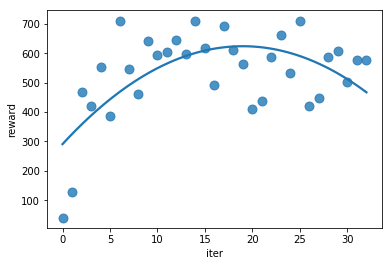

In [184]:
sns.regplot(x = 'iter', y='reward', data=df[df['model'] =='vae_reward_eval'], scatter_kws={"s": 80},
...                  order=2, ci=None, truncate=True)

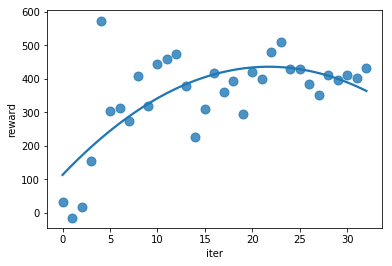

In [185]:
sns.regplot(x = 'iter', y='reward', data=df[df['model'] =='vaernn'], scatter_kws={"s": 80},
...                  order=2, ci=None, truncate=True)